# Simulate GRBs with correlations

In [23]:
%env NUMEXPR_MAX_THREADS=16
%env OMP_NUM_THREADS=1
%env MKL_NUM_THREADS=1
%env NUMEXPR_NUM_THREADS=1
%env DISPLAY=:0.0

env: NUMEXPR_MAX_THREADS=16
env: OMP_NUM_THREADS=1
env: MKL_NUM_THREADS=1
env: NUMEXPR_NUM_THREADS=1
env: DISPLAY=:0.0


In [24]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

import popsynth
from popsynth.aux_samplers.trunc_normal_aux_sampler import TruncatedNormalAuxSampler
from popsynth.aux_samplers.lognormal_aux_sampler import LogNormalAuxSampler
from zusammen.synthetic_populations.aux_samplers import TDecaySampler, DurationSampler, LumSampler, EpeakObsSampler
%matplotlib notebook
import cosmogrb

## Simulate population

In [25]:
pop_gen = popsynth.populations.SFRPopulation(r0=1./20, rise=1., decay=4.0,
                                             peak=1.5, r_max=7.0)

t90 = LogNormalAuxSampler(name="log_t90", observed=False)
t90.mu=10
t90.tau=0.25

log_ep = LogNormalAuxSampler(name="log_ep", observed=False)
log_ep.mu=300
log_ep.tau=0.4

alpha = TruncatedNormalAuxSampler(name="alpha", observed=False)
alpha.lower=-1.5
alpha.upper=0.0
alpha.mu=-1
alpha.tau=0.25

ep_tau = TruncatedNormalAuxSampler(name="ep_tau", observed=False)
ep_tau.lower=-2
ep_tau.upper=-1
ep_tau.mu=-1.5
ep_tau.tau=0.25

log_nrest = LogNormalAuxSampler(name="log_nrest", observed=False)
log_nrest.mu = 1e52
log_nrest.tau = 0.1

gamma = TruncatedNormalAuxSampler(name="gamma", observed=False)
gamma.mu = 1.5
gamma.tau = 0.5
gamma.lower = 1.0
gamma.upper = 2.0

duration = DurationSampler()
obs_lum = LumSampler()
log_ep_obs = EpeakObsSampler()

duration.set_secondary_sampler(t90)
obs_lum.set_secondary_sampler(log_ep)
obs_lum.set_secondary_sampler(log_nrest)
obs_lum.set_secondary_sampler(gamma)
log_ep_obs.set_secondary_sampler(log_ep)

pop_gen.add_observed_quantity(duration)
pop_gen.add_observed_quantity(obs_lum)
pop_gen.add_observed_quantity(log_ep_obs)
pop_gen.add_observed_quantity(alpha)
pop_gen.add_observed_quantity(ep_tau)

registering auxilary sampler: duration
registering derived luminosity sampler: obs_lum
registering auxilary sampler: log_ep_obs
registering auxilary sampler: alpha
registering auxilary sampler: ep_tau


In [30]:
population = pop_gen.draw_survey(no_selection=True, boundary=1e-2, flux_sigma=0.0, 
                                 verbose=False)
population.writeto("data/grb_pop.h5")

No Selection! Added back all objects


### Show population properties

<IPython.core.display.Javascript object>


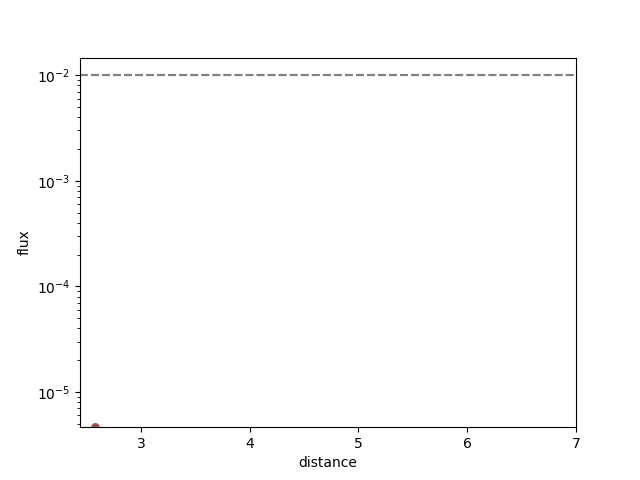

In [31]:
population.display_fluxes();

## Simulate detection

In [32]:
from corr_cpl.corr_cpl_universe import GBM_CORR_CPL_Universe
from cosmogrb.universe.survey import Survey

In [33]:
universe = GBM_CORR_CPL_Universe('data/grb_pop.h5', save_path="data")

universe.go(client=None)

universe.save('data/grb_pop_survey.h5')

In [34]:
survey = Survey.from_file('data/grb_pop_survey.h5')
survey.info()

,0
n_grbs,1
is_processed,False


## Plot detected grbs

<IPython.core.display.Javascript object>


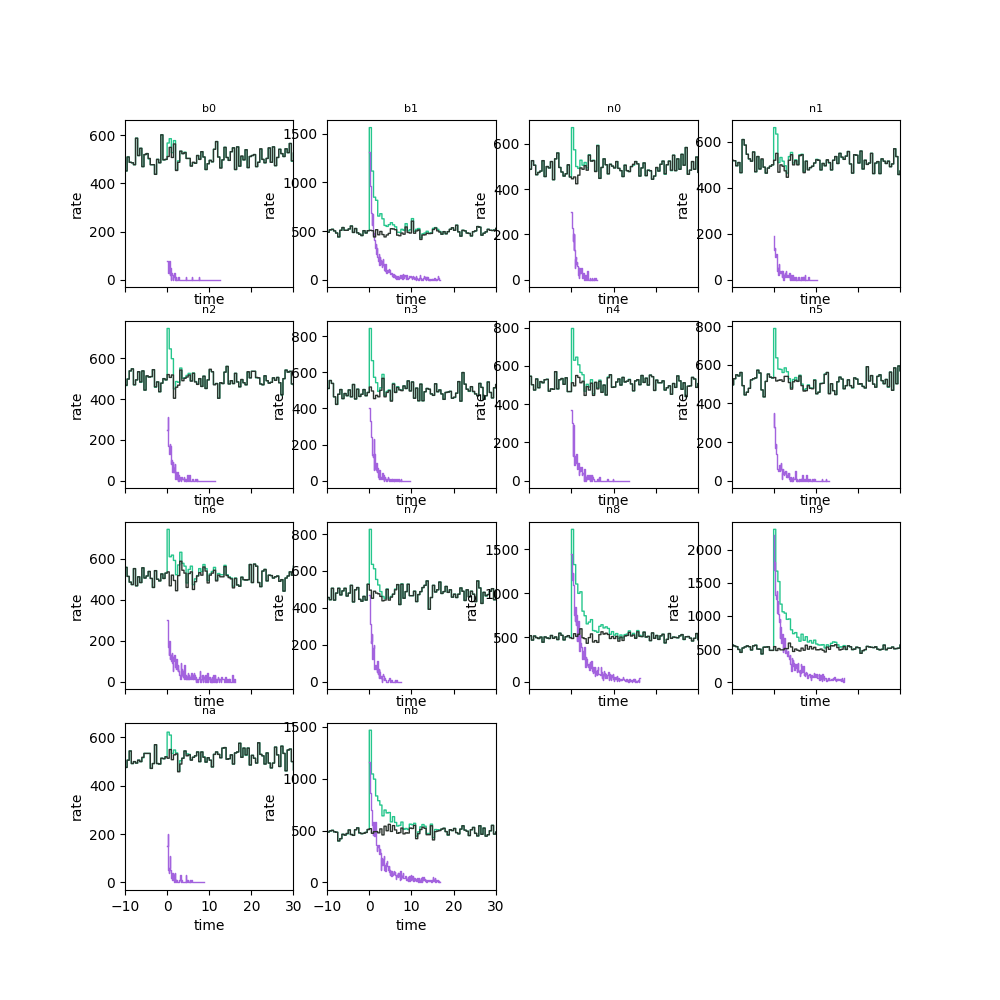

In [35]:
name = "SynthGRB_0"

fig, axes = plt.subplots(4,4,sharex=True,sharey=False,figsize=(10,10))
row=0
col = 0
for k,v  in survey[name].grb.items():
    ax = axes[row][col]

    lightcurve =v['lightcurve']

    lightcurve.display_lightcurve(dt=.5, ax=ax,lw=1,color='#25C68C')
    lightcurve.display_source(dt=0.1,ax=ax,lw=1,color="#A363DE")
    lightcurve.display_background(dt=.5,ax=ax,lw=1, color="#2C342E")
    ax.set_xlim(-10, 30)
    ax.set_title(k,size=8)

    if col < 3:
        col+=1
    else:
        row+=1
        col=0

axes[3,2].set_visible(False)
axes[3,3].set_visible(False)